In [23]:
from collections import defaultdict
import time
import random
import pandas as pd
import numpy as np
import json

from torch.utils.data import Dataset, DataLoader

In [3]:
# Functions to read in the corpus
w2i = defaultdict(lambda: len(w2i))
t2i = defaultdict(lambda: len(t2i))
UNK = w2i["<unk>"]

In [4]:
def read_dataset(filename):
    with open(filename, "r") as f:
        for line in f:
            tag, words = line.lower().strip().split(" ||| ")
            yield ([w2i[x] for x in words.split(" ")], t2i[tag])

In [13]:
# Read in the data
train = list(read_dataset(".data/classes/train.txt"))
w2i = defaultdict(lambda: UNK, w2i)
dev = list(read_dataset(".data/classes/test.txt"))
nwords = len(w2i)
ntags = len(t2i)

In [33]:
nwords, ntags

(18648, 5)

In [15]:
import torch
from torch import nn
from torch.autograd import Variable

class BoW(torch.nn.Module):
    def __init__(self, nwords, ntags):
        super(BoW, self).__init__()

        """ variables """
        type = torch.FloatTensor
        use_cuda = torch.cuda.is_available()

        if use_cuda:
            type = torch.cuda.FloatTensor

        self.bias = Variable(torch.zeros(ntags),
                             requires_grad=True).type(type)

        """ layers """
        self.embedding = nn.Embedding(nwords, ntags)
        # initialize the weights with xavier uniform (Glorot, X. & Bengio, Y. (2010))
        nn.init.xavier_uniform_(self.embedding.weight)


    def forward(self, words):
        emb = self.embedding(words)
        out = torch.sum(emb, dim=0) + self.bias # size(out) = N
        out = out.view(1, -1) # size(out) = 1 x N
        return out

In [16]:
# initialize the model
model = BoW(nwords, ntags)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

type = torch.LongTensor

In [18]:
for ITER in range(10):
    # Perform training
    random.shuffle(train)
    train_loss = 0.0
    start = time.time()
    for words, tag in train:
        words = torch.tensor(words).type(type)
        tag = torch.tensor([tag]).type(type)
        scores = model(words)
        loss = criterion(scores, tag)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("iter %r: train loss/sent=%.4f, time=%.2fs" % (ITER, train_loss/len(train), time.time()-start))
    # Perform testing
    test_correct = 0.0
    for words, tag in dev:
        words = torch.tensor(words).type(type)
        scores = model(words)[0].detach().cpu().numpy()
        predict = np.argmax(scores)
        if predict == tag:
            test_correct += 1
    print("iter %r: test acc=%.4f" % (ITER, test_correct/len(dev)))

iter 0: train loss/sent=0.9920, time=41.03s
iter 0: test acc=0.4127
iter 1: train loss/sent=0.8235, time=41.46s
iter 1: test acc=0.4032
iter 2: train loss/sent=0.7045, time=40.93s
iter 2: test acc=0.4145
iter 3: train loss/sent=0.6139, time=44.26s
iter 3: test acc=0.4059
iter 4: train loss/sent=0.5428, time=40.76s
iter 4: test acc=0.4041
iter 5: train loss/sent=0.4849, time=45.02s
iter 5: test acc=0.4041
iter 6: train loss/sent=0.4369, time=42.72s
iter 6: test acc=0.4005
iter 7: train loss/sent=0.3968, time=43.64s
iter 7: test acc=0.4027
iter 8: train loss/sent=0.3622, time=43.49s
iter 8: test acc=0.3955
iter 9: train loss/sent=0.3320, time=42.57s
iter 9: test acc=0.3950


### CNN

In [9]:
import spacy
import torch
from torchtext import data
from torchtext import datasets
import random

SEED = 1234

torch.manual_seed(SEED)

nlp = spacy.load('en')

In [10]:
TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:14<00:00, 5.62MB/s]


In [41]:
train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [42]:
TEXT.build_vocab(train_data, max_size=25000, vectors="glove.6B.100d")
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:57, 2.06MB/s]                               
100%|█████████▉| 399283/400000 [00:40<00:00, 19925.17it/s]

In [43]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), 
                                                                           batch_size=BATCH_SIZE)

### Custom data

In [34]:
def read_dataset(filename):
    with open(filename, "r") as f:
        with open('.data/dumps.json', 'w') as outfile: 
            for line in f:
                tag, words = line.lower().strip().split(" ||| ")
                d = {"text": words, "label": tag }
                outfile.write("{}\n".format(json.dumps(d)))

read_dataset(".data/classes/train.txt")

In [37]:
classes = data.TabularDataset(
    path='.data/dumps.json', format='json',
    fields={'text': ('t', data.Field(sequential=True)),
             'label': ('l', data.Field(sequential=False))})

In [38]:
classes.examples[0].t

['the',
 'rock',
 'is',
 'destined',
 'to',
 'be',
 'the',
 '21st',
 'century',
 "'s",
 'new',
 '``',
 'conan',
 "''",
 'and',
 'that',
 'he',
 "'s",
 'going',
 'to',
 'make',
 'a',
 'splash',
 'even',
 'greater',
 'than',
 'arnold',
 'schwarzenegger',
 ',',
 'jean-claud',
 'van',
 'damme',
 'or',
 'steven',
 'segal',
 '.']

In [40]:
classes.examples[0].l

'3'

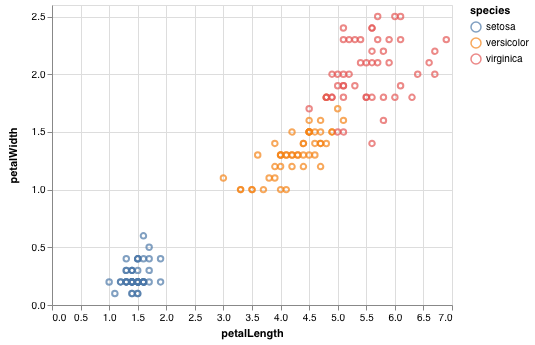

In [1]:
import altair as alt
from vega_datasets import data

# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

iris = data.iris()

alt.Chart(iris).mark_point().encode(
    x='petalLength',
    y='petalWidth',
    color='species'
)

In [2]:
import pandas as pd
data = pd.DataFrame({'a': list('CCCDDDEEE'),
                     'b': [2, 7, 4, 1, 2, 6, 8, 4, 7]})

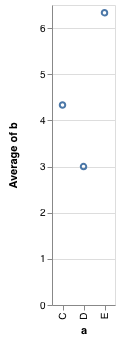

In [8]:
alt.Chart(data).mark_point().encode(x='a',y='average(b)',)